In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data_upsampled.csv')

In [3]:
#csv doesnt have categories as categories so make sure
cat_cols = ['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'MaritalStatus', 'DayOfWeekClaimed', 
                       'MonthClaimed', 'WeekOfMonthClaimed','PolicyType', 'VehicleCategory', 'VehiclePrice', 
                      'RepNumber', 'DriverRating', 'Days:Policy-Accident', 'Days:Policy-Claim', 
                      'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 
                      'AddressChange-Claim', 'NumberOfCars', 'Year']
for col in cat_cols:
    df[col] = df[col].astype('category')

In [4]:
df = df.iloc[: , 1:]

In [5]:
len(df)

28992

In [6]:
data = df.groupby('label', group_keys=False).apply(lambda x: x.sample(5000, random_state = 39))

# K- Fold Cross Val

In [7]:
X = data.iloc[:,:-1]
y = data['label'].array
gnb = GaussianNB()
tree = DecisionTreeClassifier(random_state=39)
knn = KNeighborsClassifier(n_neighbors=3)
svm = LinearSVC(random_state=39, dual = False)
log = LogisticRegression(solver='lbfgs', max_iter=10000, random_state = 39)
rf = RandomForestClassifier(max_depth=2, random_state=39)
cv = StratifiedKFold(n_splits=10, random_state=39, shuffle=True)
models = [gnb, tree, knn, log, rf, svm]

In [8]:
for model in models:
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
    print('Mean Accuracy of {}: %.3f (%.3f)'.format(str(model)) % (np.mean(scores), np.std(scores))) 
    print('Min and Max Accuracy of {}: %.3f (%.3f)'.format(str(model)) % (scores.min(), scores.max()))

Mean Accuracy of GaussianNB(): 0.723 (0.011)
Min and Max Accuracy of GaussianNB(): 0.711 (0.747)
Mean Accuracy of DecisionTreeClassifier(random_state=39): 0.934 (0.009)
Min and Max Accuracy of DecisionTreeClassifier(random_state=39): 0.921 (0.952)
Mean Accuracy of KNeighborsClassifier(n_neighbors=3): 0.859 (0.006)
Min and Max Accuracy of KNeighborsClassifier(n_neighbors=3): 0.847 (0.867)
Mean Accuracy of LogisticRegression(max_iter=10000, random_state=39): 0.739 (0.009)
Min and Max Accuracy of LogisticRegression(max_iter=10000, random_state=39): 0.725 (0.754)
Mean Accuracy of RandomForestClassifier(max_depth=2, random_state=39): 0.743 (0.011)
Min and Max Accuracy of RandomForestClassifier(max_depth=2, random_state=39): 0.727 (0.759)
Mean Accuracy of LinearSVC(dual=False, random_state=39): 0.739 (0.009)
Min and Max Accuracy of LinearSVC(dual=False, random_state=39): 0.725 (0.753)


# Train/test split

In [9]:
#split into stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=39, stratify = y)
train, test = train_test_split(data, test_size=0.34, random_state=39, stratify = data['label'])
print(len(train[train['label'] == 1]) / len(train))
print(len(test[test['label'] == 1]) / len(test))

0.49992423094408245
0.5001470155836518


# Helper Functions

In [10]:
def mcc(Tp, Tn, Fp, Fn):
    top = (Tp * Tn) - (Fp * Fn)
    bot = (Tp + Fp) * (Tp + Fn) * (Tn + Fp) * (Tn + Fn)
    botS = bot**0.5
    return (top / botS)

In [11]:
def metrics(model, test, title, title2, col): 
    y_pred = model.predict(test)
    cf = confusion_matrix(y_test, y_pred)
    n = len(y_test)
    n0 = (np.count_nonzero(y_test == 0))
    n1 = (np.count_nonzero(y_test == 1))
    w0 = n0/n
    w1 = n1/n
    n = cf.sum().sum()
    tn = cf[0][0]
    fp = cf[0][1]
    tp = cf[1][1]
    fn = cf[1][0]
    tpr0 = tn / (tn + fp) 
    tpr1 = tp / (tp + fn)
    fpr0 = 1 - tpr1
    fpr1 = 1 - tpr0
    pre0 = tn / (tn + fn)
    pre1 = tp / (tp + fp)
    rec0 = tpr0
    rec1 = tpr1
    f0 = (2 * pre0 * rec0) / (pre0 + rec0)
    f1 = (2 * pre1 * rec1) / (pre1 + rec1)
    mcc0 = mcc(tp, tn, fp, fn)
    mcc1 = mcc0
    if(title2 == 'SVM'):
        roc0 = roc_auc_score(y_test, model._predict_proba_lr(test)[:, 1])
    else: 
        roc0 = roc_auc_score(y_test, model.predict_proba(test)[:, 1])
    roc1 = roc0
    row0 = ['Legitimate', tpr0, fpr0, pre0, rec0, f0, mcc0, roc0]
    row1 = ['Fraudulent', tpr1, fpr1, pre1, rec1, f1, mcc1, roc1]
    row2 = [ 'Weighted Avg', (tpr0 * w0 + tpr1 * w1), (fpr0 * w0 + fpr1 * w1), 
            (pre0 * w0 + pre1 * w1), (rec0 * w0 + rec1 * w1), 
            (f0 * w0 + f1 * w1), mcc0, roc0]
  
    df = pd.DataFrame(columns=('Class', 'TP Rate', 'FP Rate', 'Precision', 'Recall', "F-Measure", 
                              'MCC', 'ROC-AUC'))
    df.loc[0] = row0
    df.loc[1] = row1
    df.loc[2] = row2
    counts = ['{0:0.0f}'.format(i) for i in cf.flatten()]
    counts = np.asarray(counts).reshape(2,2)
    labs = ['Legitimate', 'Fraudulent']
    ax = plt.axes()
    sns.heatmap(cf, annot=counts, fmt='', cmap= col, xticklabels=labs, yticklabels=labs)
    tit = title + title2
    ax.set_title(tit)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show
    print(df.to_string(index = False))

In [12]:
n = len(y_train)
n0 = (np.count_nonzero(y_train == 0))
n1 = (np.count_nonzero(y_train == 1))
nClass = 2
w0 = n / (nClass * n0)
w1 = n / (nClass * n1)
weights = []
for i in range(n):
    if(y_train[i] == 0):
        weights.append(w0)
    else:
        weights.append(w1)

## K Best Features - 15 Chi^2 Selection

In [13]:
selector = SelectKBest(chi2, k =15)
selector.fit(X_train, y_train)
X_kbest = X_train.iloc[:, selector.get_support()]
test_kbest = X_test.iloc[:, selector.get_support()]
models = [gnb, tree, knn, log, rf, svm]
mod_name = ['Naive Bayes', 'Decision Tree', 'KNN', 'Logistic Regression', 'Random Forest', 'SVM']
test_kbest.shape[1]

15

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.580000 0.129336   0.817579 0.580000   0.678596 0.471019 0.767135
  Fraudulent 0.870664 0.420000   0.674715 0.870664   0.760267 0.471019 0.767135
Weighted Avg 0.725375 0.274711   0.746126 0.725375   0.719443 0.471019 0.767135


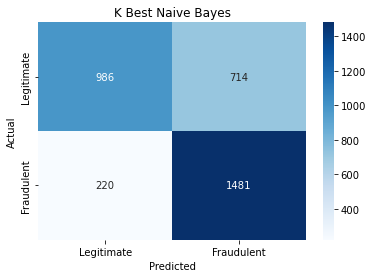

In [14]:
mod = gnb.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "K Best ", mod_name[0], 'Blues')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.862353 0.011758   0.986541 0.862353   0.920276 0.857444 0.925217
  Fraudulent 0.988242 0.137647   0.877807 0.988242   0.929757 0.857444 0.925217
Weighted Avg 0.925316 0.074721   0.932158 0.925316   0.925018 0.857444 0.925217


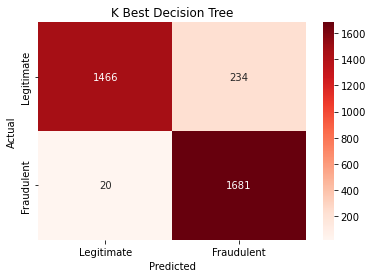

In [15]:
mod = tree.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "K Best ", mod_name[1], 'Reds')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.682353 0.051146   0.930233 0.682353   0.787241 0.654926 0.886767
  Fraudulent 0.948854 0.317647   0.749304 0.948854   0.837354 0.654926 0.886767
Weighted Avg 0.815642 0.184436   0.839741 0.815642   0.812305 0.654926 0.886767


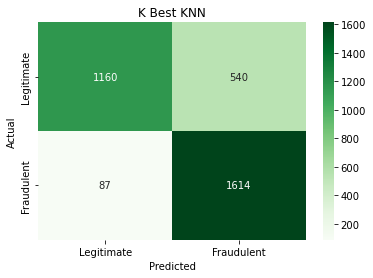

In [16]:
mod = knn.fit(X_kbest, y_train)
metrics(mod, test_kbest, "K Best ", mod_name[2], 'Greens')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.625882 0.151088   0.805450 0.625882   0.704403 0.487079 0.788225
  Fraudulent 0.848912 0.374118   0.694231 0.848912   0.763819 0.487079 0.788225
Weighted Avg 0.737430 0.262635   0.749824 0.737430   0.734120 0.487079 0.788225


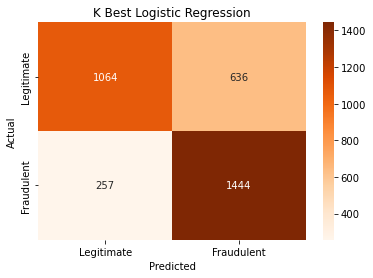

In [17]:
mod = log.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "K Best ", mod_name[3], 'Oranges')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.571765 0.069371   0.891743 0.571765   0.696774 0.538279 0.787266
  Fraudulent 0.930629 0.428235   0.684985 0.930629   0.789133 0.538279 0.787266
Weighted Avg 0.751250 0.248856   0.788334 0.751250   0.742967 0.538279 0.787266


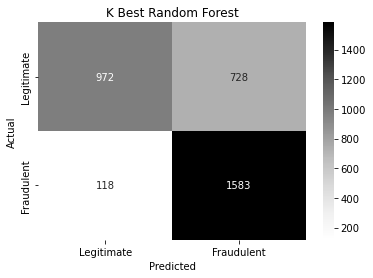

In [18]:
mod = rf.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "K Best ", mod_name[4], 'Greys')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.604118 0.138154   0.813788 0.604118   0.693450 0.482274 0.787486
  Fraudulent 0.861846 0.395882   0.685367 0.861846   0.763542 0.482274 0.787486
Weighted Avg 0.733020 0.267056   0.749558 0.733020   0.728506 0.482274 0.787486


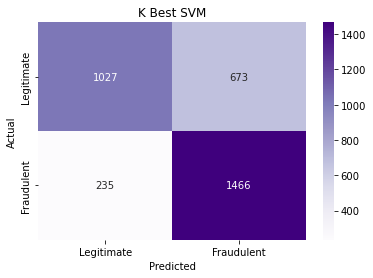

In [19]:
mod = svm.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "K Best ", mod_name[5], 'Purples')

In [20]:
test_kbest.columns

Index(['Month', 'DayOfWeek', 'MonthClaimed', 'Sex', 'Age', 'Fault',
       'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Deductible',
       'PastNumberOfClaims', 'AgeOfPolicyHolder', 'NumberOfSuppliments',
       'AddressChange-Claim', 'BasePolicy'],
      dtype='object')

# Select Based On False Positives

In [21]:
from sklearn.feature_selection import SelectFpr
selector = SelectFpr(chi2, alpha = 0.01)
selector.fit(X_train, y_train)
X_kbest = X_train.iloc[:, selector.get_support()]
test_kbest = X_test.iloc[:, selector.get_support()]
test_kbest.shape[1]

17

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.580000 0.129336   0.817579 0.580000   0.678596 0.471019 0.766903
  Fraudulent 0.870664 0.420000   0.674715 0.870664   0.760267 0.471019 0.766903
Weighted Avg 0.725375 0.274711   0.746126 0.725375   0.719443 0.471019 0.766903


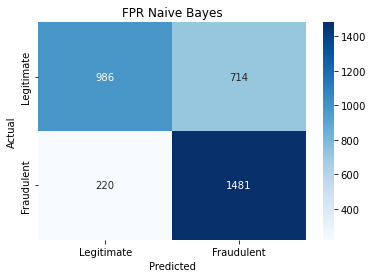

In [22]:
mod = gnb.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "FPR ", mod_name[0], 'Blues')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.860000 0.007055   0.991859 0.860000   0.921235 0.860614 0.926432
  Fraudulent 0.992945 0.140000   0.876492 0.992945   0.931092 0.860614 0.926432
Weighted Avg 0.926492 0.073547   0.934158 0.926492   0.926165 0.860614 0.926432


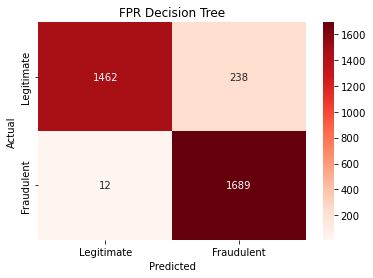

In [23]:
mod = tree.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "FPR ", mod_name[1], 'Reds')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.691176 0.065256   0.913686 0.691176   0.787006 0.645387 0.891462
  Fraudulent 0.934744 0.308824   0.751773 0.934744   0.833333 0.645387 0.891462
Weighted Avg 0.812996 0.187075   0.832706 0.812996   0.810176 0.645387 0.891462


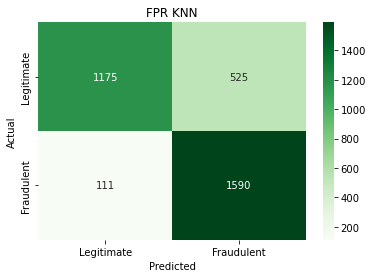

In [24]:
mod = knn.fit(X_kbest, y_train)
metrics(mod, test_kbest, "FPR ", mod_name[2], "Greens")

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.624706 0.156379   0.799699 0.624706   0.701453 0.479985  0.78879
  Fraudulent 0.843621 0.375294   0.692233 0.843621   0.760466 0.479985  0.78879
Weighted Avg 0.734196 0.265869   0.745950 0.734196   0.730968 0.479985  0.78879


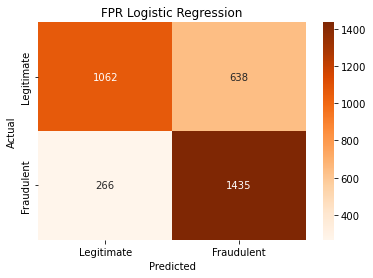

In [25]:
mod = log.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "FPR ", mod_name[3], 'Oranges')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.573529 0.089359   0.865129 0.573529   0.689777 0.514301 0.791651
  Fraudulent 0.910641 0.426471   0.681179 0.910641   0.779371 0.514301 0.791651
Weighted Avg 0.742135 0.257964   0.773127 0.742135   0.734587 0.514301 0.791651


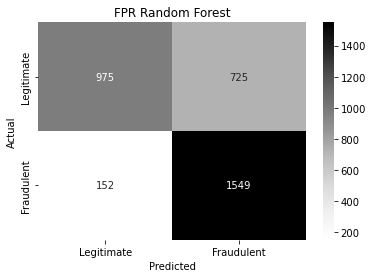

In [26]:
mod = rf.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "FPR ", mod_name[4], 'Greys')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.602353 0.135215   0.816587 0.602353   0.693297 0.484125 0.788101
  Fraudulent 0.864785 0.397647   0.685142 0.864785   0.764553 0.484125 0.788101
Weighted Avg 0.733608 0.266469   0.750845 0.733608   0.728936 0.484125 0.788101


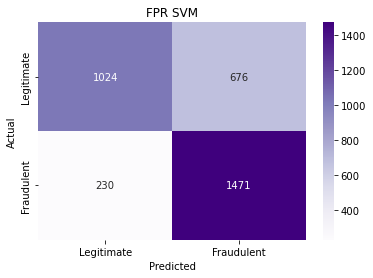

In [27]:
mod = svm.fit(X_kbest, y_train, sample_weight = weights)
metrics(mod, test_kbest, "FPR ", mod_name[5], 'Purples')

In [28]:
test_kbest.columns

Index(['Month', 'DayOfWeek', 'MonthClaimed', 'Sex', 'Age', 'Fault',
       'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Deductible',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
       'NumberOfSuppliments', 'AddressChange-Claim', 'Year', 'BasePolicy'],
      dtype='object')

# Sequential Feature Selector

In [29]:
from sklearn.feature_selection import SequentialFeatureSelector
models = [gnb, tree, knn, log, rf, svm]
for i in range(len(models)):
    sfs = SequentialFeatureSelector(models[i], n_features_to_select=6)
    sfs.fit(X_train, y_train)
    if(i == 0):
        gnb_train = X_train.iloc[:, sfs.get_support()]
        gnb_test = X_test.iloc[:, sfs.get_support()]
    elif(i ==1):
        tree_train = X_train.iloc[:, sfs.get_support()]
        tree_test = X_test.iloc[:, sfs.get_support()]
    elif(i ==2):
        knn_train = X_train.iloc[:, sfs.get_support()]
        knn_test = X_test.iloc[:, sfs.get_support()]
    elif(i ==3):
        log_train = X_train.iloc[:, sfs.get_support()]
        log_test = X_test.iloc[:, sfs.get_support()]
    elif(i==4):
        rf_train = X_train.iloc[:, sfs.get_support()]
        rf_test = X_test.iloc[:, sfs.get_support()]
    else:
        svm_train = X_train.iloc[:, sfs.get_support()]
        svm_test = X_test.iloc[:, sfs.get_support()]

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.568824 0.087008   0.867265 0.568824   0.687034 0.513195 0.777673
  Fraudulent 0.912992 0.431176   0.679353 0.912992   0.779032 0.513195 0.777673
Weighted Avg 0.740959 0.259143   0.773281 0.740959   0.733046 0.513195 0.777673


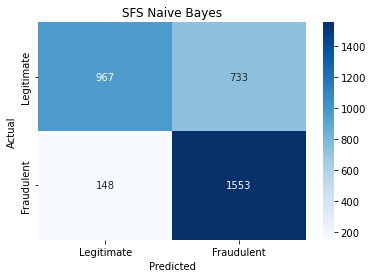

In [30]:
mod = gnb.fit(gnb_train, y_train, sample_weight = weights)
metrics(mod, gnb_test, "SFS ", mod_name[0], 'Blues')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.828824 0.005879   0.992953 0.828824   0.903495 0.834457 0.911319
  Fraudulent 0.994121 0.171176   0.853179 0.994121   0.918273 0.834457 0.911319
Weighted Avg 0.911497 0.088552   0.923045 0.911497   0.910886 0.834457 0.911319


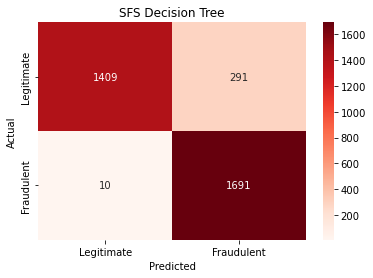

In [31]:
mod = tree.fit(tree_train, y_train, sample_weight = weights)
metrics(mod, tree_test, "SFS ", mod_name[1], 'Reds')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.694118 0.050558   0.932070 0.694118   0.795684 0.665655 0.887999
  Fraudulent 0.949442 0.305882   0.756440 0.949442   0.842023 0.665655 0.887999
Weighted Avg 0.821817 0.178258   0.844229 0.821817   0.818860 0.665655 0.887999


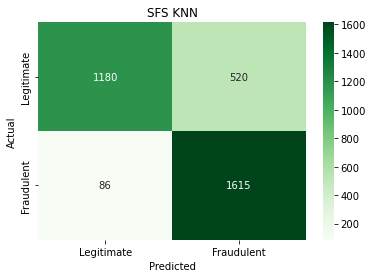

In [32]:
mod = knn.fit(knn_train, y_train)
metrics(mod, knn_test, "SFS ", mod_name[2], 'Greens')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.574706 0.098765   0.853275 0.574706   0.686819 0.503567 0.771619
  Fraudulent 0.901235 0.425294   0.679521 0.901235   0.774829 0.503567 0.771619
Weighted Avg 0.738018 0.262078   0.766373 0.738018   0.730837 0.503567 0.771619


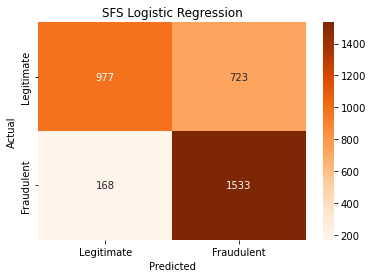

In [33]:
mod = log.fit(log_train, y_train, sample_weight = weights)
metrics(mod, log_test, "SFS ", mod_name[3], 'Oranges')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.564118 0.048795   0.920345 0.564118   0.699489 0.558931 0.790453
  Fraudulent 0.951205 0.435882   0.685884 0.951205   0.797044 0.558931 0.790453
Weighted Avg 0.757718 0.242395   0.803080 0.757718   0.748281 0.558931 0.790453


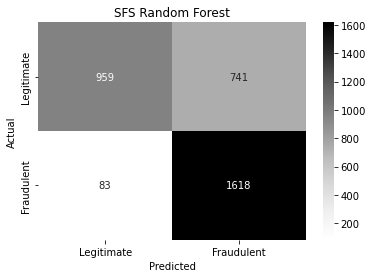

In [34]:
mod = rf.fit(rf_train, y_train, sample_weight = weights)
metrics(mod, rf_test, "SFS ", mod_name[4], 'Greys')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.587059 0.116402   0.834448 0.587059   0.689227 0.492846 0.782386
  Fraudulent 0.883598 0.412941   0.681633 0.883598   0.769585 0.492846 0.782386
Weighted Avg 0.735372 0.264715   0.758018 0.735372   0.729418 0.492846 0.782386


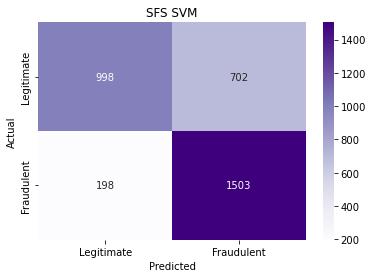

In [35]:
mod = svm.fit(svm_train, y_train, sample_weight = weights)
metrics(mod, svm_test, "SFS ", mod_name[5], 'Purples')

In [36]:
svm_train.columns

Index(['Age', 'Fault', 'VehicleCategory', 'VehiclePrice', 'Days:Policy-Claim',
       'BasePolicy'],
      dtype='object')

# Percentile Selection: Top 25%

In [37]:
from sklearn.feature_selection import SelectPercentile
selector = SelectPercentile(f_classif, percentile=25)
selector.fit(X_train, y_train)
X_pbest = X_train.iloc[:, selector.get_support()]
test_pbest = X_test.iloc[:, selector.get_support()]
test_pbest.shape[1]

8

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.578824 0.122869   0.824811 0.578824   0.680263 0.477726 0.762504
  Fraudulent 0.877131 0.421176   0.675725 0.877131   0.763367 0.477726 0.762504
Weighted Avg 0.728021 0.272067   0.750246 0.728021   0.721827 0.477726 0.762504


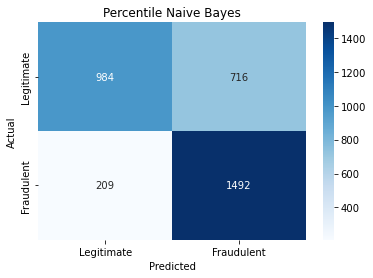

In [38]:
mod = gnb.fit(X_pbest, y_train, sample_weight = weights)
metrics(mod, test_pbest, "Percentile ", mod_name[0], 'Blues')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.692941 0.067019   0.911765 0.692941   0.787433 0.644803 0.864696
  Fraudulent 0.932981 0.307059   0.752489 0.932981   0.833071 0.644803 0.864696
Weighted Avg 0.812996 0.187074   0.832104 0.812996   0.810259 0.644803 0.864696


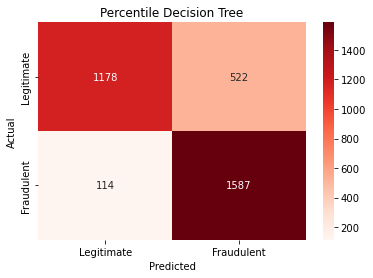

In [39]:
mod = tree.fit(X_pbest, y_train, sample_weight = weights)
metrics(mod, test_pbest, "Percentile ", mod_name[1], 'Reds')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.671176 0.112287   0.856607 0.671176   0.752639 0.572493 0.826736
  Fraudulent 0.887713 0.328824   0.729821 0.887713   0.801061 0.572493 0.826736
Weighted Avg 0.779477 0.220587   0.793195 0.779477   0.776857 0.572493 0.826736


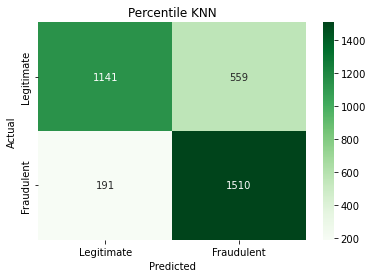

In [40]:
mod = knn.fit(X_pbest, y_train)
metrics(mod, test_pbest, "Percentile ", mod_name[2], 'Greens')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.590000 0.145797   0.801759 0.590000   0.679770 0.460586 0.769614
  Fraudulent 0.854203 0.410000   0.675814 0.854203   0.754609 0.460586 0.769614
Weighted Avg 0.722141 0.277937   0.738768 0.722141   0.717200 0.460586 0.769614


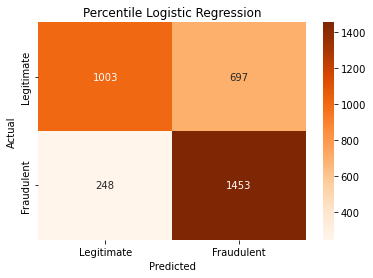

In [41]:
mod = log.fit(X_pbest, y_train, sample_weight = weights)
metrics(mod, test_pbest, "Percentile ", mod_name[3], 'Oranges')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.570588 0.088183   0.866071 0.570588   0.687943 0.513235 0.780508
  Fraudulent 0.911817 0.429412   0.679965 0.911817   0.779006 0.513235 0.780508
Weighted Avg 0.741253 0.258848   0.772991 0.741253   0.733488 0.513235 0.780508


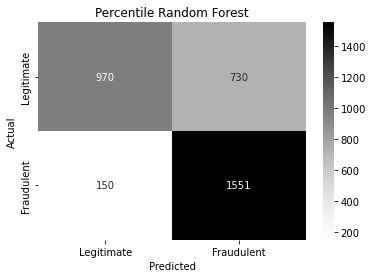

In [42]:
mod = rf.fit(X_pbest, y_train, sample_weight = weights)
metrics(mod, test_pbest, "Percentile ", mod_name[4], 'Greys')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.581765 0.132275   0.814662 0.581765   0.678792 0.469097 0.770366
  Fraudulent 0.867725 0.418235   0.674897 0.867725   0.759259 0.469097 0.770366
Weighted Avg 0.724787 0.275297   0.744759 0.724787   0.719037 0.469097 0.770366


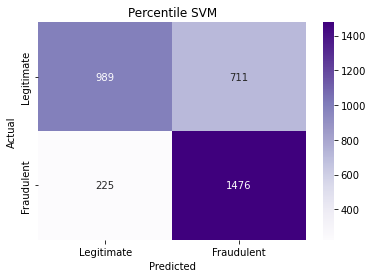

In [43]:
mod = svm.fit(X_pbest, y_train, sample_weight = weights)
metrics(mod, test_pbest, "Percentile ", mod_name[5], 'Purples')

In [44]:
test_pbest.columns

Index(['Month', 'MonthClaimed', 'Fault', 'PolicyType', 'VehicleCategory',
       'PastNumberOfClaims', 'NumberOfSuppliments', 'BasePolicy'],
      dtype='object')

# False Discovery Error Reduction

In [45]:
from sklearn.feature_selection import SelectFdr
selector = SelectFdr(chi2, alpha = 0.05)
selector.fit(X_train, y_train)
X_fdr = X_train.iloc[:, selector.get_support()]
test_fdr = X_test.iloc[:, selector.get_support()]
test_fdr.shape[1]

18

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.596471 0.138742   0.811200 0.596471   0.687458 0.474689 0.769253
  Fraudulent 0.861258 0.403529   0.681079 0.861258   0.760644 0.474689 0.769253
Weighted Avg 0.728903 0.271175   0.746120 0.728903   0.724061 0.474689 0.769253


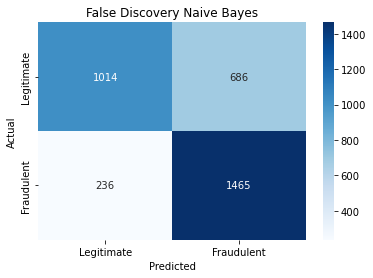

In [46]:
mod = gnb.fit(X_fdr, y_train, sample_weight = weights)
metrics(mod, test_fdr, "False Discovery ", mod_name[0], 'Blues')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.867059 0.008230   0.990591 0.867059   0.924718 0.865614 0.929375
  Fraudulent 0.991770 0.132941   0.881861 0.991770   0.933592 0.865614 0.929375
Weighted Avg 0.929433 0.070604   0.936210 0.929433   0.929156 0.865614 0.929375


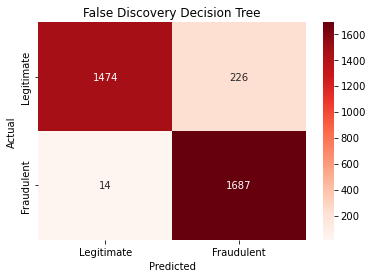

In [47]:
mod = tree.fit(X_fdr, y_train, sample_weight = weights)
metrics(mod, test_fdr, "False Discovery ", mod_name[1], 'Reds')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.690000 0.065256   0.913551 0.690000   0.786193 0.644371 0.891376
  Fraudulent 0.934744 0.310000   0.751063 0.934744   0.832897 0.644371 0.891376
Weighted Avg 0.812408 0.187664   0.832283 0.812408   0.809552 0.644371 0.891376


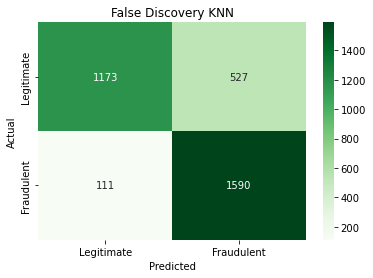

In [48]:
mod = knn.fit(X_fdr, y_train)
metrics(mod, test_fdr, "False Discovery ", mod_name[2], 'Greens')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.625294 0.155203   0.801055 0.625294   0.702346 0.481858 0.789582
  Fraudulent 0.844797 0.374706   0.692864 0.844797   0.761325 0.481858 0.789582
Weighted Avg 0.735078 0.264987   0.746944 0.735078   0.731844 0.481858 0.789582


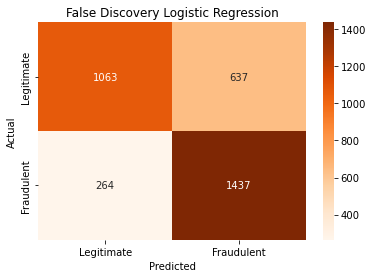

In [49]:
mod = log.fit(X_fdr, y_train, sample_weight = weights)
metrics(mod, test_fdr, "False Discovery ", mod_name[3], 'Oranges')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.572941 0.088183   0.866548 0.572941   0.689802 0.515272 0.789507
  Fraudulent 0.911817 0.427059   0.681159 0.911817   0.779789 0.515272 0.789507
Weighted Avg 0.742429 0.257671   0.773826 0.742429   0.734808 0.515272 0.789507


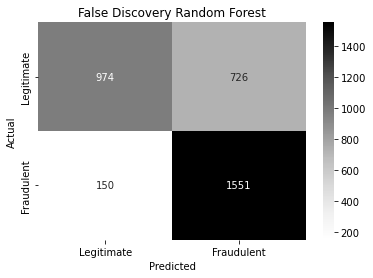

In [50]:
mod = rf.fit(X_fdr, y_train, sample_weight = weights)
metrics(mod, test_fdr, "False Discovery ", mod_name[4], 'Greys')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.602941 0.133451   0.818690 0.602941   0.694444 0.486724 0.788918
  Fraudulent 0.866549 0.397059   0.685900 0.866549   0.765714 0.486724 0.788918
Weighted Avg 0.734784 0.265294   0.752276 0.734784   0.730090 0.486724 0.788918


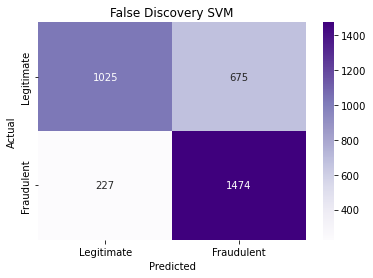

In [51]:
mod = svm.fit(X_fdr, y_train, sample_weight = weights)
metrics(mod, test_fdr, "False Discovery ", mod_name[5], 'Purples')

In [52]:
test_fdr.columns

Index(['Month', 'DayOfWeek', 'MonthClaimed', 'Sex', 'Age', 'Fault',
       'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Deductible',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
       'PoliceReportFiled', 'NumberOfSuppliments', 'AddressChange-Claim',
       'Year', 'BasePolicy'],
      dtype='object')

# Variance Threshold

In [53]:
from sklearn.feature_selection import VarianceThreshold
selector =  VarianceThreshold(threshold=(.75 * (1 - .75)))
selector.fit(X_train, y_train)
X_vbest = X_train.iloc[:, selector.get_support()]
test_vbest = X_test.iloc[:, selector.get_support()]
test_vbest.shape[1]

22

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.395882 0.121105   0.765643 0.395882   0.521908 0.313827 0.687177
  Fraudulent 0.878895 0.604118   0.592784 0.878895   0.708027 0.313827 0.687177
Weighted Avg 0.637460 0.362682   0.679188 0.637460   0.614995 0.313827 0.687177


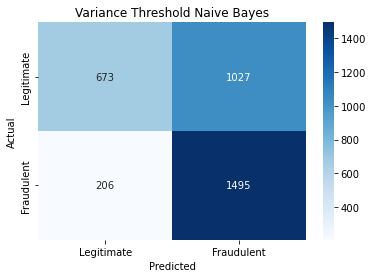

In [54]:
mod = gnb.fit(X_vbest, y_train, sample_weight = weights)
metrics(mod, test_vbest, "Variance Threshold ", mod_name[0], 'Blues')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.807647 0.015285   0.981415 0.807647   0.886092 0.805118 0.896181
  Fraudulent 0.984715 0.192353   0.836663 0.984715   0.904672 0.805118 0.896181
Weighted Avg 0.896207 0.103845   0.909018 0.896207   0.895385 0.805118 0.896181


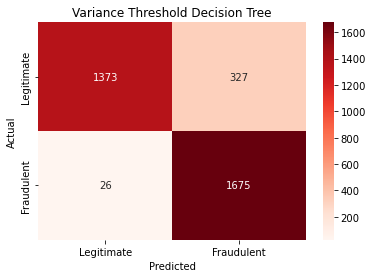

In [55]:
mod = tree.fit(X_vbest, y_train, sample_weight = weights)
metrics(mod, test_vbest, "Variance Threshold ", mod_name[1], 'Reds')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.687647 0.068783   0.909020 0.687647   0.782987 0.638111  0.88191
  Fraudulent 0.931217 0.312353   0.748936 0.931217   0.830189 0.638111  0.88191
Weighted Avg 0.809468 0.190604   0.828955 0.809468   0.806595 0.638111  0.88191


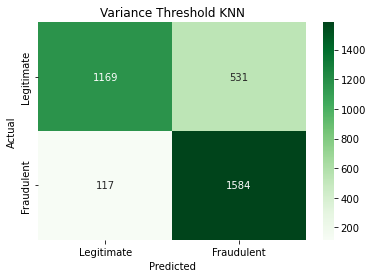

In [56]:
mod = knn.fit(X_vbest, y_train)
metrics(mod, test_vbest, "Variance Threshold ", mod_name[2], 'Greens')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.548824 0.249853   0.687040 0.548824   0.610203 0.305226 0.702706
  Fraudulent 0.750147 0.451176   0.624572 0.750147   0.681624 0.305226 0.702706
Weighted Avg 0.649515 0.350544   0.655797 0.649515   0.645924 0.305226 0.702706


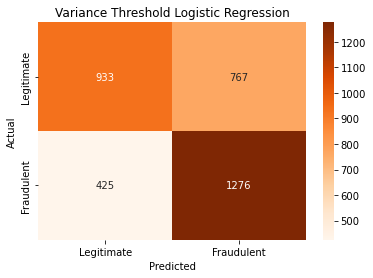

In [57]:
mod = log.fit(X_vbest, y_train, sample_weight = weights)
metrics(mod, test_vbest, "Variance Threshold ", mod_name[3], 'Oranges')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.356471 0.069371   0.837017 0.356471   0.500000 0.350684 0.717024
  Fraudulent 0.930629 0.643529   0.591334 0.930629   0.723161 0.350684 0.717024
Weighted Avg 0.643634 0.356535   0.714139 0.643634   0.611613 0.350684 0.717024


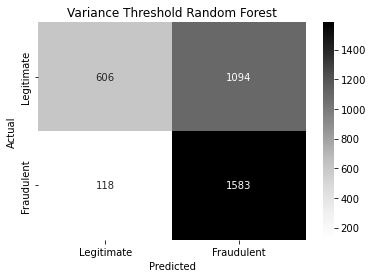

In [58]:
mod = rf.fit(X_vbest, y_train, sample_weight = weights)
metrics(mod, test_vbest, "Variance Threshold ", mod_name[4], 'Greys')

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.537647 0.233980   0.696646 0.537647   0.606906 0.311916 0.703403
  Fraudulent 0.766020 0.462353   0.623743 0.766020   0.687599 0.311916 0.703403
Weighted Avg 0.651867 0.348200   0.660184 0.651867   0.647264 0.311916 0.703403


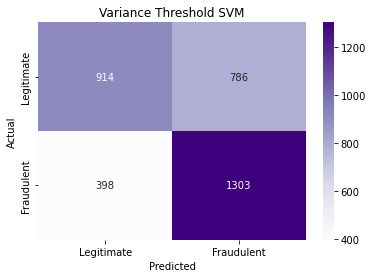

In [59]:
mod = svm.fit(X_vbest, y_train, sample_weight = weights)
metrics(mod, test_vbest, "Variance Threshold ", mod_name[5], 'Purples')

In [60]:
test_vbest.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'DayOfWeekClaimed',
       'MonthClaimed', 'WeekOfMonthClaimed', 'MaritalStatus', 'Age',
       'PolicyType', 'VehicleCategory', 'VehiclePrice', 'RepNumber',
       'Deductible', 'DriverRating', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange-Claim',
       'Year', 'BasePolicy'],
      dtype='object')

# Performance of Best Model No Selection

       Class  TP Rate  FP Rate  Precision   Recall  F-Measure      MCC  ROC-AUC
  Legitimate 0.848824 0.008230   0.990391 0.848824   0.914159 0.849346 0.920297
  Fraudulent 0.991770 0.151176   0.867798 0.991770   0.925652 0.849346 0.920297
Weighted Avg 0.920318 0.079724   0.929077 0.920318   0.919907 0.849346 0.920297


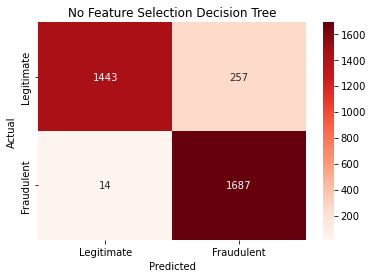

In [62]:
mod = tree.fit(X_train, y_train, sample_weight = weights)
metrics(mod, X_test, "No Feature Selection ", mod_name[1], 'Reds')